## Описание проекта

В рамках проекта необходимо разработать алгорим, который будет предлагать клиенту похожие товары, на основе просмотренной карточки. \
В целях оптимизации алгоритма заказчик предоставил информацию о всех представленных позициях в магазине и размеченные в ручном режиме данные, на основании которых необходимо оценить точность разработанного алгоритма. \
Поскольку заказчик не предоставил информацию о целевой метрике алгоритма, в рамках проекта принимаем за цель метрику accuracy >= 0.6, что будет означать достаточно высокую степень соответствия просматриваемого товара и рекомендации

## Импорты и настройки

In [1]:
import numpy as np
import pandas as pd

import faiss

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize, StandardScaler, Normalizer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

from feature_engine.selection import DropFeatures, DropCorrelatedFeatures


import phik

## Загрузка и работа с данными

In [2]:
# Поскольку данные о товарах имеют достаточно большой размер,
# необходимо предварительно все числовые поля сконвертировать в float32
# что позволит существенно сэкономить место

base_for_cols = pd.read_csv('datasets/data_workshop_2/base.csv', nrows=100)


float_cols = [c for c in base_for_cols if base_for_cols[c].dtype == 'float64']
float32_cols = {c: np.float32 for c in float_cols}

In [3]:
# загружаем данные о товарах

base = pd.read_csv('datasets/data_workshop_2/base.csv', dtype=float32_cols)

# загружаем размеченные данные
train = pd.read_csv('datasets/data_workshop_2/train.csv', dtype=float32_cols)

# загружаем проверочный датасет

val = pd.read_csv('datasets/data_workshop_2/validation.csv', dtype=float32_cols)

# загружаем правильные ответы для проверочного датасета

val_res = pd.read_csv('datasets/data_workshop_2/validation_answer.csv', dtype=float32_cols)

In [4]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float32
 2   1       float32
 3   2       float32
 4   3       float32
 5   4       float32
 6   5       float32
 7   6       float32
 8   7       float32
 9   8       float32
 10  9       float32
 11  10      float32
 12  11      float32
 13  12      float32
 14  13      float32
 15  14      float32
 16  15      float32
 17  16      float32
 18  17      float32
 19  18      float32
 20  19      float32
 21  20      float32
 22  21      float32
 23  22      float32
 24  23      float32
 25  24      float32
 26  25      float32
 27  26      float32
 28  27      float32
 29  28      float32
 30  29      float32
 31  30      float32
 32  31      float32
 33  32      float32
 34  33      float32
 35  34      float32
 36  35      float32
 37  36      float32
 38  37      float32
 39  38      float32
 40  

Датасет не имеет пропусков \
Общий объем данных 823,8 mb

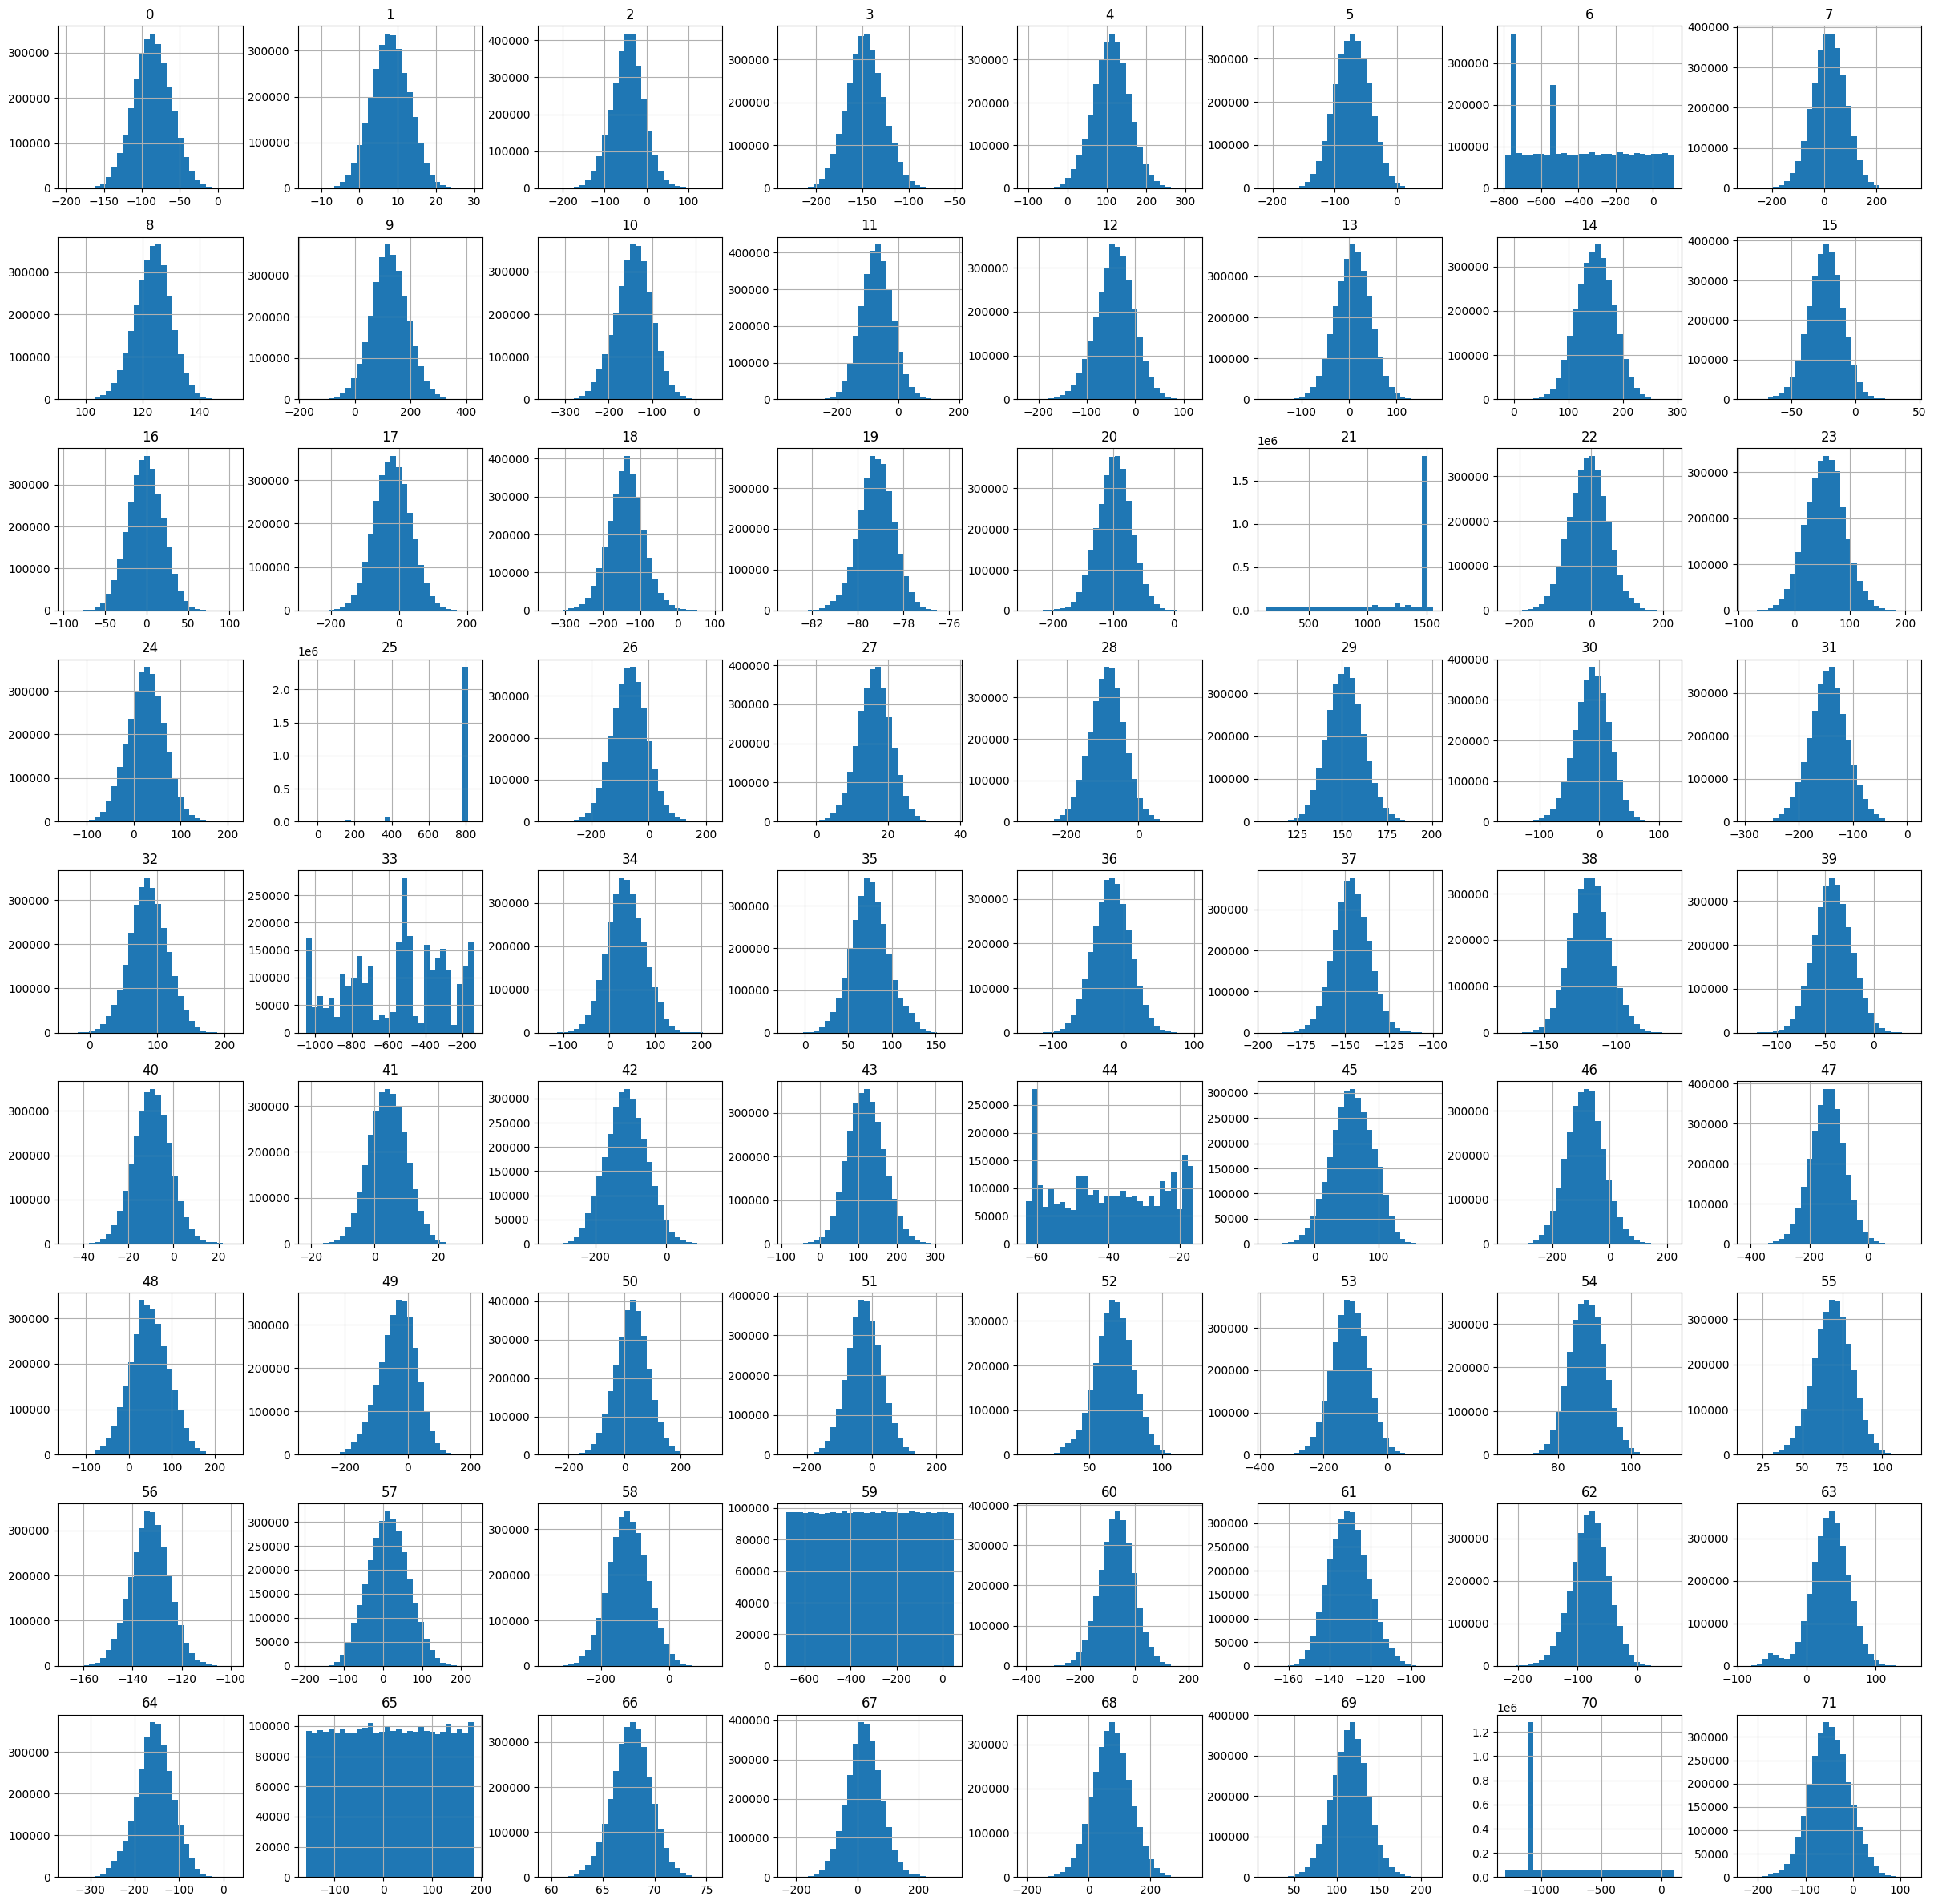

In [5]:
base.hist(bins=30, figsize=(30,30));

array([[<AxesSubplot: title={'center': '6'}>,
        <AxesSubplot: title={'center': '21'}>,
        <AxesSubplot: title={'center': '25'}>],
       [<AxesSubplot: title={'center': '33'}>,
        <AxesSubplot: title={'center': '44'}>,
        <AxesSubplot: title={'center': '59'}>],
       [<AxesSubplot: title={'center': '65'}>,
        <AxesSubplot: title={'center': '70'}>, <AxesSubplot: >]],
      dtype=object)

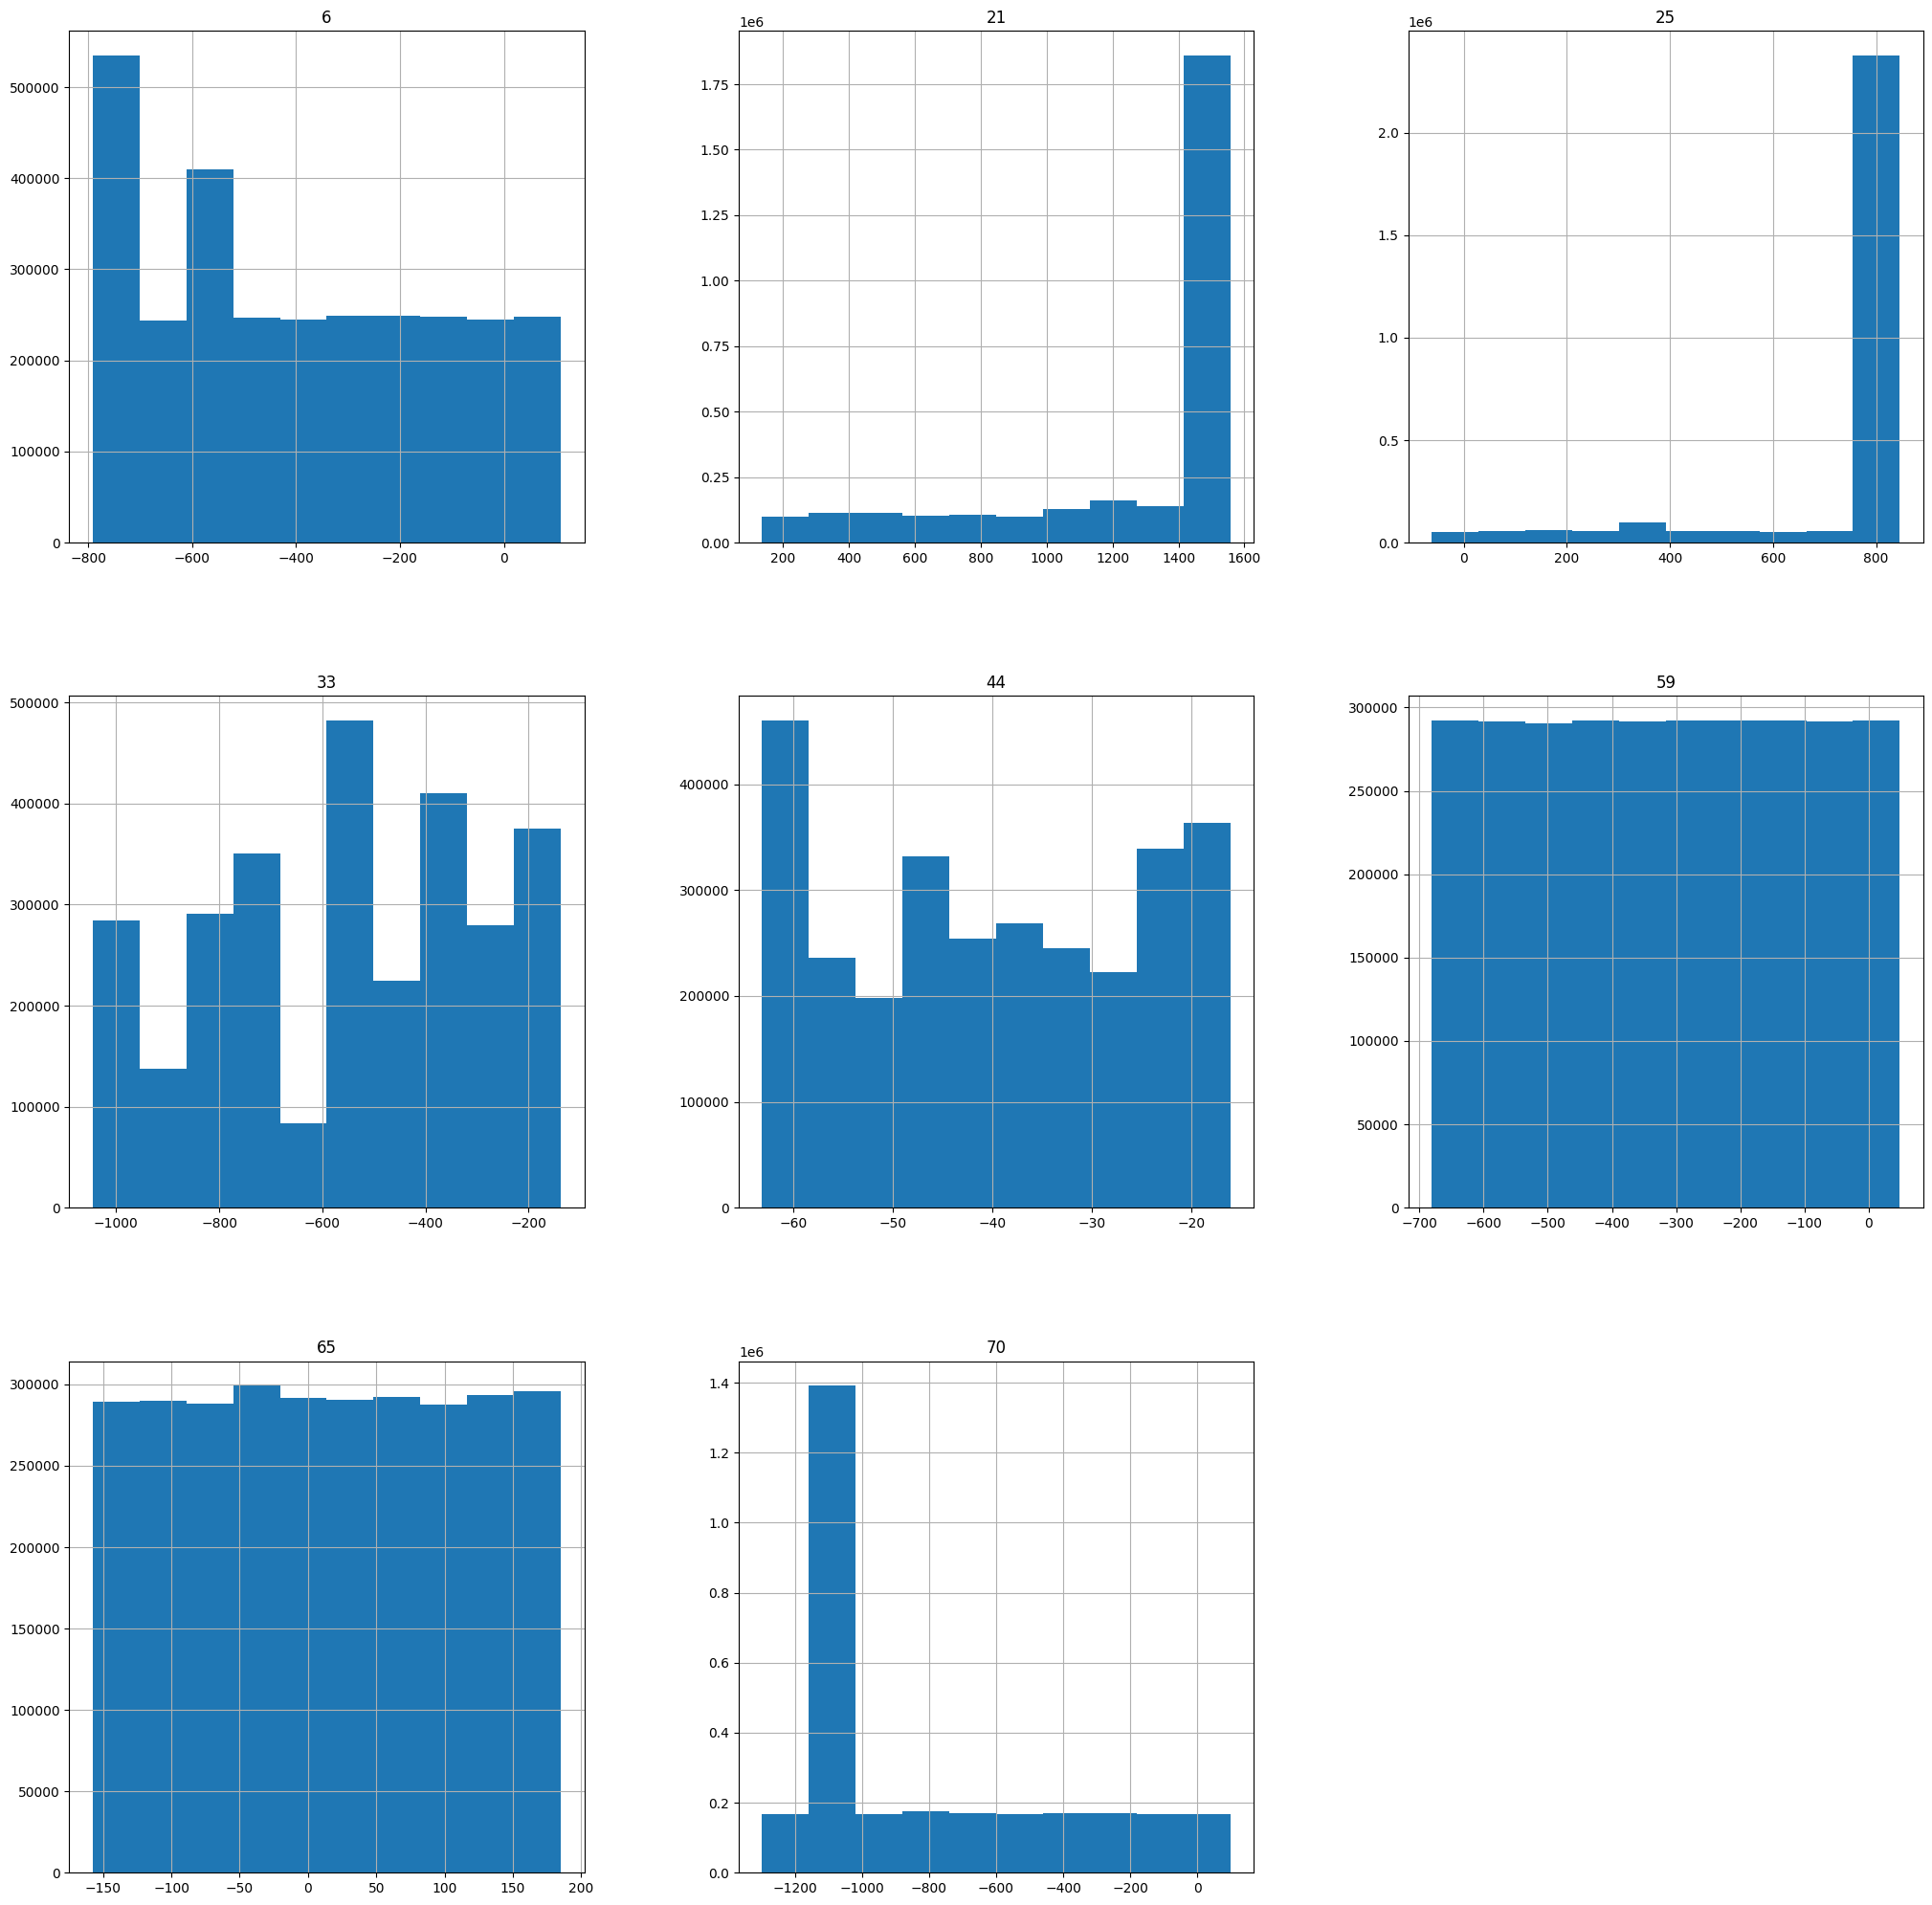

In [6]:
base[['6', '21', '25', '33', '44', '59', '65', '70']].hist(figsize=(25,25))

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(ax=ax, data=train.drop(columns=['Id']).phik_matrix(interval_cols=[
    '0', '1', '2',
    '3', '4', '5',
    '6', '7', '8',
    '9', '10','11',
    '12', '13', '14',
    '15', '16', '17',
    '18', '19', '20',
    '21', '22', '23',
    '24', '25', '26',
    '27', '28', '29',
    '30', '31', '32',
    '33', '34', '35',
    '36', '37', '38',
    '39', '40', '41',
    '42', '43', '44',
    '45', '46', '47',
    '48', '49', '50',
    '51', '52', '53',
    '54', '55', '56',
    '57', '58', '59',
    '60', '61', '62',
    '63', '64', '65',
    '66', '67', '68',
    '69', '70', '71'
]))

C:\Users\Ivanovsv3\AppData\Roaming\Python\Python39\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable Target is large: 91794. Are you sure this is not an interval variable? Analysis for pairs of variables including Target can be slow.
  warnings.warn(


In [ ]:
#features_to_drop = ['Id', ]
features_to_drop = ['Id', '33', '59']

In [ ]:
#Созадим пайплайн для предобработки данных


#numer = make_column_selector(dtype_include='number')
numer = ['6', '21', '25', '33', '44', '59', '65', '70']
numer = [i for i in numer if i not in features_to_drop]

transformer = make_column_transformer(
    #(Normalizer(), numer),
    (StandardScaler(), numer),
    remainder='passthrough',
    verbose_feature_names_out=False)

# next_transformer = make_column_transformer(
#     (StandardScaler(), numer),
#     remainder='drop',
#     verbose_feature_names_out=True
# )

pipe = Pipeline([
    ('drop', DropFeatures(features_to_drop=features_to_drop)),
    ('normal', transformer),
    ('norm', Normalizer())
    #('scaler', StandardScaler())
])


In [ ]:
pipe

In [ ]:
# Для упрощения трансформаций датасетов напишем функцию

def transformation(df):
    transformed = pd.DataFrame(
        pipe.fit_transform(df),
        columns=pipe.get_feature_names_out(),
        dtype='float32'
)
    return transformed

In [ ]:
base_info = transformation(base)


In [ ]:
# Проверяем распределение после обработки

base_info.hist(figsize=(30,30));


In [ ]:
train_info = transformation(train.drop(columns=['Target']))

In [ ]:
nlist = 1000
d = base_info.shape[1]
quantiser = faiss.IndexFlatL2(d)
#index = faiss.IndexIVFFlat(quantiser, d, nlist, faiss.METRIC_L2)
index = faiss.index_factory(d, 'IVF1000,Flat')

In [ ]:
index.reset()
index.nprobe = 16
print(index.is_trained)

index.train(base_info)


print(index.is_trained)
index.add(base_info)

print(index.ntotal)

In [ ]:
distances, indexes = index.search(train_info, 5)

In [ ]:
print('Средняя дистанция между векторами:',distances.mean())

In [ ]:
def accuracy_n(targets, predict, base_index):
    acc = 0
    accuracy_list = []
    for target, predicted in zip(targets['Target'].tolist(), predict.tolist()):
        acc += int(target in [base_index.loc[number, 'Id'] for number in predicted])
    for x in range(0,5):
        ind = [i[x] for i in predict]
        accuracy_list.append(accuracy_score(targets.reset_index()['Target'].to_numpy(), base.loc[ind, 'Id']))
    result = 100 * acc / len(predict)
    cumsum = np.array(accuracy_list).cumsum()

    print('Нарастающий итог accuracy@5:', cumsum)
    print(f'Accuracy@5: {result}%')

    fig, ax = plt.subplots()
    sns.lineplot(ax=ax, data=cumsum)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Iteration')
    ax.set_title('Нарастающий итог Accuracy@5')
    
    plt.show()
    
    return (result, cumsum)



In [ ]:
acc_5, cumsum = accuracy_n(train, indexes, base)

## Проверка на Valid

In [ ]:
val_info = transformation(val)

In [ ]:
distances, indexes = index.search(val_info, 5)

In [ ]:
val_res = val_res.rename(columns={'Expected': 'Target'})

In [ ]:
acc_5, cumsum = accuracy_n(val_res, indexes, base)

## Заключение

В рамках проекта была произведена преодобработка и кластеризация данных о товарах. \
Были отобраны 8 признаков, имеющих не стандартное распределение. По данным признакам была произведена стандартизация, что позволило использовать их при дальнейшей обработке. \
На основании сформированных кластеров был произведен поиск топ-5 ближайших к заданному товару для показа аналогов.
В резульате анализа полученных рекомендаций, точность превышает заданную планку в 60%